<a href="https://colab.research.google.com/github/Ayrsz/SignalAndSistemyProject/blob/main/Model%20Machine%20Learning/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ML
import sklearn as sk
import xgboost as xgb

# Scientific computation
import numpy as np
import jax
import jax.numpy as jnp

# Plot and view
from matplotlib import pyplot as plt
import seaborn as sea

# Data manipulation
import os
import gc
import pandas as pd
import cv2 as cv

# Audio manipulation
import librosa
import soundfile as sf


# Mount Project

In [9]:

try:
    from google.colab import drive

    drive.mount("/content/drive", force_remount=True)
except Exception as e:
    print(e)
    print("Código rodando localmente")

path_root = "/content/drive/MyDrive/Datasets/DatasetAudios/Data"


Mounted at /content/drive


# Dataset config

In [10]:
data = pd.read_csv(path_root + "/feats.csv")
data.head()

,name,dir_image,rms_mean,rms_std,zero_cross_mean,zero_cross_std,amplitude_envelope_mean,amplitude_envelope_std,spectral_centroid_mean,spectral_centroid_std,...,mfcc#16_mean,mfcc#16_std,mfcc#17_mean,mfcc#17_std,mfcc#18_mean,mfcc#18_std,mfcc#19_mean,mfcc#19_std,tempo,label
0,jazz.00000.wav,/content/drive/MyDrive/Datasets/DatasetAudios/...,0.0508,0.0339,0.0784,0.0513,0.1274,0.1125,1503.9323,744.7082,...,-1.5087,6.4102,0.2145,7.4582,-1.9955,7.0713,-3.3545,7.0625,[123],jazz
1,jazz.00001.wav,/content/drive/MyDrive/Datasets/DatasetAudios/...,0.0238,0.0138,0.0593,0.0340,0.0606,0.0453,1266.4884,549.4456,...,-5.1893,6.5770,-5.4284,6.7586,-3.1186,7.2550,-0.7986,9.9127,[135],jazz
2,jazz.00002.wav,/content/drive/MyDrive/Datasets/DatasetAudios/...,0.0825,0.0250,0.0579,0.0309,0.2369,0.1321,1064.7191,401.3362,...,-12.2968,7.3947,-6.7681,6.7589,-3.5002,6.4369,-8.6486,8.5671,[151],jazz
3,jazz.00003.wav,/content/drive/MyDrive/Datasets/DatasetAudios/...,0.0620,0.0313,0.0446,0.0150,0.1581,0.1027,813.4170,304.7387,...,-2.2756,7.3898,3.8764,6.2338,0.3421,7.0754,-2.2192,7.5043,[92],jazz
4,jazz.00004.wav,/content/drive/MyDrive/Datasets/DatasetAudios/...,0.1111,0.0391,0.0477,0.0239,0.2448,0.1079,1039.4057,349.9304,...,1.9802,13.4625,4.9817,12.7413,6.5850,19.8337,-2.4146,21.7525,[64],jazz


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5994 entries, 0 to 5993
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     5994 non-null   object 
 1   dir_image                5994 non-null   object 
 2   rms_mean                 5994 non-null   float64
 3   rms_std                  5994 non-null   float64
 4   zero_cross_mean          5994 non-null   float64
 5   zero_cross_std           5994 non-null   float64
 6   amplitude_envelope_mean  5994 non-null   float64
 7   amplitude_envelope_std   5994 non-null   float64
 8   spectral_centroid_mean   5994 non-null   float64
 9   spectral_centroid_std    5994 non-null   float64
 10  hog_mean                 5994 non-null   float64
 11  hog_std                  5994 non-null   float64
 12  band_mean                5994 non-null   float64
 13  band_std                 5994 non-null   float64
 14  bandwidth_mean          

# Treating data

In [12]:
labeling = lambda name: name.split("_")[0]
data["label"] = data["label"].apply(labeling)

In [13]:
unvetorize = lambda num: float(num.strip("[]"))


data["tempo"] = data["tempo"].apply(unvetorize)

# Alguns estão com tempo 0, vou resolver
data = data[data["tempo"] != 0]

In [16]:
# Dicionario, label -> Idx (labelEnconder)
# Transformar classes em numeros
label_mapping = {label: int(idx) for idx, label in enumerate(data["label"].unique())}
label_unmapping = {int(idx): label for label, idx in label_mapping.items()}
data["label"] = data["label"].map(label_mapping)

In [17]:
data = data.dropna()

# Exploratory analysis

In [18]:
color_genres = {
    "pop": "magenta",
    "jazz": "brown",
    "hiphop": "green",
    "metal": "#720058",
    "reggae": "red",
    "classical": "goldenrod",
    "blues": "turquoise",
    "disco": "darkblue",
    "rock": "dimgray",
    "country": "peru",
}

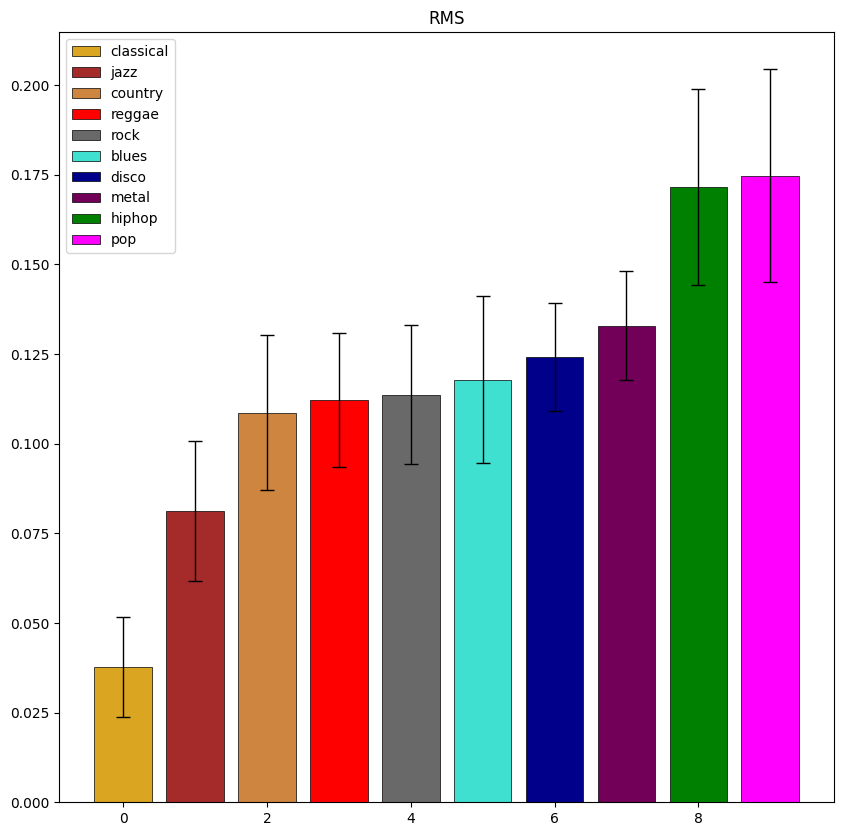

In [19]:
def plot_bar(df : str, column_mean_target : str, column_std_target : str = None, title : str = "graph"):
    labels = np.unique(df["label"])
    means = {}
    stds = {}

    for label in labels:
        name_genre = label_unmapping[label]

        rms_genre = df[df["label"] == label][column_mean_target]
        mean = rms_genre.mean()

        means[name_genre] = mean

        try:
            std_genre = df[df["label"] == label][column_std_target]
            std = std_genre.mean()
            stds[name_genre] = std
        except:
            stds[name_genre] = 0


    means = dict(sorted(means.items(), key=lambda item: item[1]))

    fig = plt.figure(figsize= (10, 10))
    plt.title(title)

    i = 0
    for label, value in means.items():
        plt.bar(
            i,
            value,
            color=color_genres[label],
            edgecolor="black",
            linewidth=0.5,
            label=label,
            yerr=stds[label],
            error_kw={"elinewidth": 1, "ecolor": "black", "capsize": 5},

        )
        i = i + 1

    ax = plt.gca()
    ax.axes.xaxis.set_visible(True)
    plt.legend(means.keys(), loc = "upper left")






plot_bar(data, "rms_mean", "rms_std", "RMS")


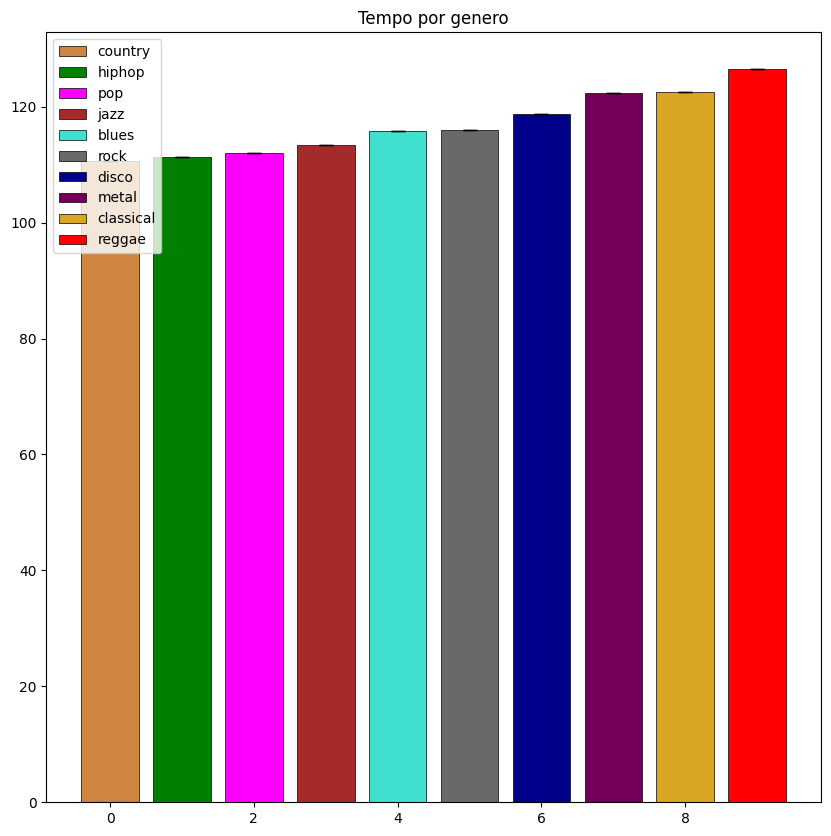

In [20]:
plot_bar(data, "tempo",  title = "Tempo por genero")

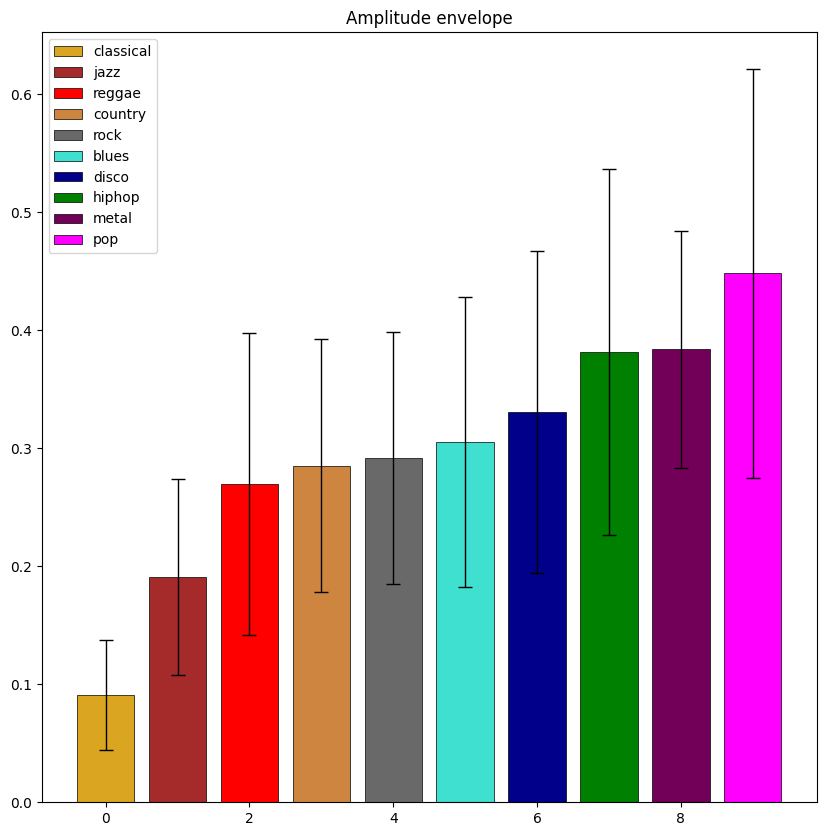

In [ ]:
plot_bar(data, "amplitude_envelope_mean", "amplitude_envelope_std", "Amplitude envelope")

In [ ]:
def plot_audio_with_respective_spectro(audio, dir_image):

    a = librosa.display.specshow(audio)

nome_audio = "metal.00001.wav"
audio_to_print, sr = librosa.load("/home/mas11/Documents/Datasets/Data/genres_original/metal/"+nome_audio)
dir_image = data[data["name"] == nome_audio]["dir_image"]
print(dir_image)
plot_audio_with_respective_spectro(audio_to_print, dir_image)

1382    /home/mas11/Documents/Datasets/Data/images/met...
Name: dir_image, dtype: object


IndexError: tuple index out of range

# Model

In [21]:
non_feat = ["label", "dir_image", "name"]

columns = data.columns
data_feat = data.drop(columns=non_feat)
data_non_feat = data.drop(columns=data_feat.columns)

names = data["name"]
dir_imgs = data["dir_image"]
labels = data["label"]


In [22]:
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(
    data_feat, labels, test_size=0.2
)

## Alguns modelos, para comparação


In [100]:
xgboost = xgb.XGBClassifier(n_estimators=1000)
xgboost.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
gradient_boost = sk.sklearn.ensemble.GradientBoostingClassifier()
gradient_boost.fit(X_train, Y_train)

In [ ]:
decision_tree = sk.sklearn.tree.DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

In [ ]:
random_forest = sk.sklearn.ensemble.RandomForestClassifier()
random_forest.fit(X_train, Y_train)

## Comparing and model choice

In [97]:
def get_precision(models, names):
    precisoes = {}
    largura_nome = max(len(name) for name in names) + 2
    largura_precisao = 10
    print(f"{'Modelo'.ljust(largura_nome)} | {'Precisão'.ljust(largura_precisao)}")
    print("-" * (largura_nome + largura_precisao + 3))


    for model, name in zip(models, names):
        pred = model.predict(X_test)
        precisao = sk.sklearn.metrics.accuracy_score(Y_test, pred) * 100
        precisoes[name] = precisao
        print(f"{name.ljust(largura_nome)} | {precisao:.2f}%".ljust(largura_nome + largura_precisao + 3))

    largura_nome = max(len(name) for name in names) + 2
    largura_precisao = 10

    return precisoes

previsoes_todos_modelos = get_precision([xgboost, gradient_boost, decision_tree, random_forest], ["xgb", "gradb", "dectree", "rand_forest"])





Modelo        | Precisão  
--------------------------
xgb           | 84.32%    
gradb         | 76.90%    
dectree       | 54.71%    
rand_forest   | 78.15%    


# XGBoost

In [103]:
pred = xgboost.predict(X_test)
acuracia = previsoes_todos_modelos["xgb"]

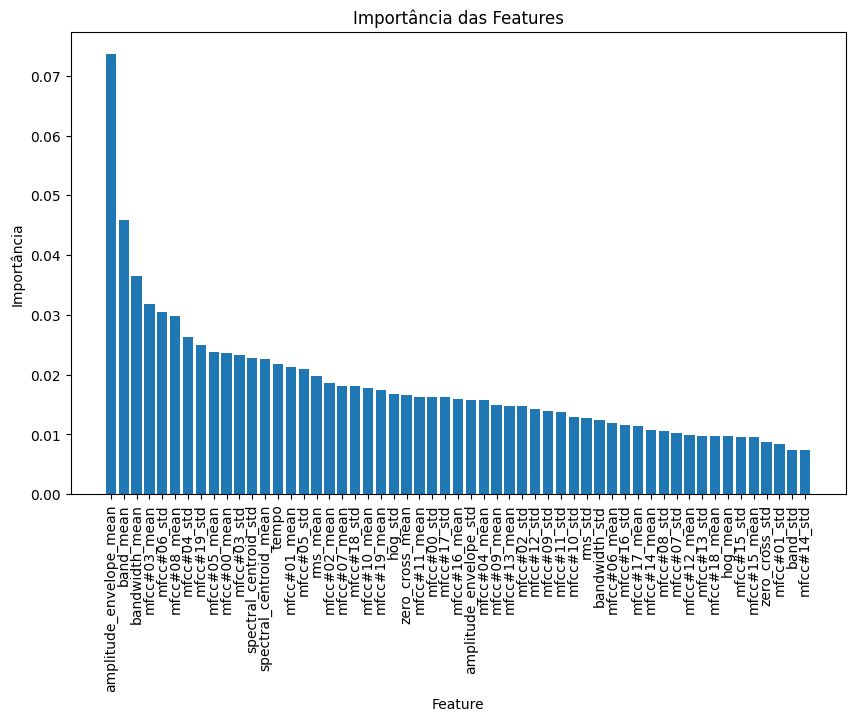

In [104]:
def plot_importance(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title("Importância das Features")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(
        range(X_train.shape[1]), np.array(data_feat.columns)[indices], rotation=90
    )
    plt.xlabel("Feature")
    plt.ylabel("Importância")
    plt.show()


plot_importance(xgboost)

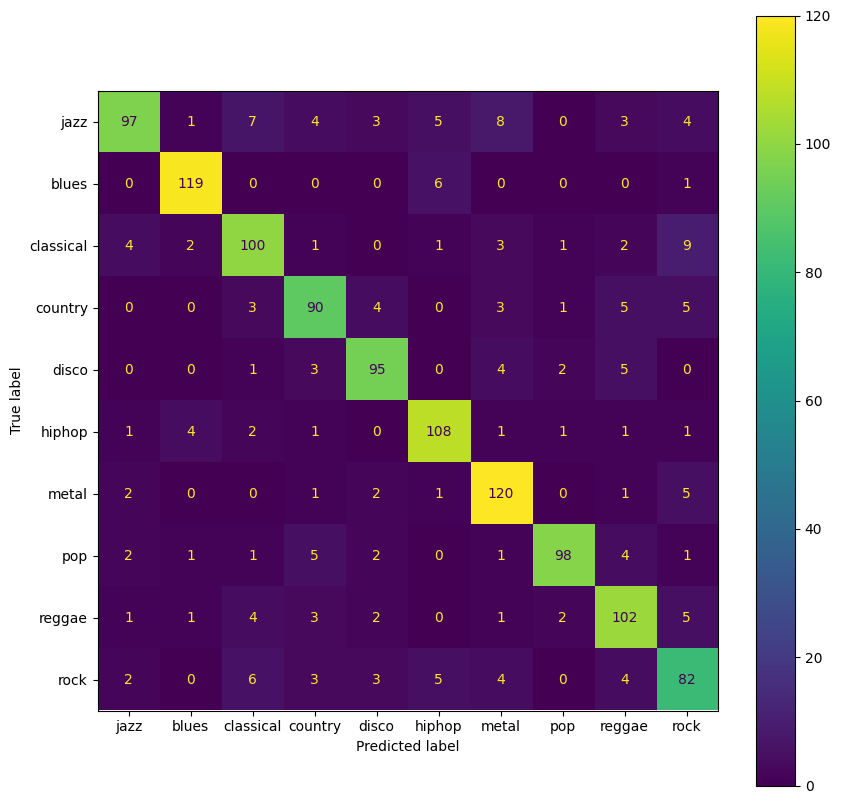

In [105]:
Y_right = [label_unmapping[i] for i in Y_test]
pred_right = [label_unmapping[i] for i in pred]
conf_matrix = sk.metrics.confusion_matrix(Y_right, pred_right)


def show_conf(conf_matrix):
    labels = label_unmapping.values()
    disp = sk.metrics.ConfusionMatrixDisplay(
        confusion_matrix=conf_matrix, display_labels=labels
    )

    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax)


show_conf(conf_matrix)


# Testando inputs abtrários